In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.naive_bayes import GaussianNB

The dataset used is found on kaggle and named 'cannabis.csv'. Link: https://www.kaggle.com/kingburrito666/cannabis-strains 

The dataset consists of 6 features: Strain (name of strain), Type (indica, sativa or hybrid), Rating (from 0-5), Effects, Flavour, Description. 

Data Pre-processing

In [2]:
#Opening and reading data. The data was corrupted with some non utf-8 encodable characters 
#so import while replacing errors with spaces
data = open('cannabis.csv' ,encoding="utf-8", errors='replace')
data = pd.read_csv(data, low_memory = False)

#Removing abnormal symbols and characters
data = data.replace('�','',regex=True).astype(str)
data = data.replace('۝','',regex=True).astype(str)

#Converting strings in cells to lists of strings
data['Flavor'] = data['Flavor'].apply(lambda x: x.split(','))
data['Effects'] = data['Effects'].apply(lambda x: x.split(','))

#Sanity Check
data.head()

,Strain,Type,Rating,Effects,Flavor,Description
0,100-Og,hybrid,4.0,"[Creative, Energetic, Tingly, Euphoric, Relaxed]","[Earthy, Sweet, Citrus]",$100 OG is a 50/50 hybrid strain that packs a ...
1,98-White-Widow,hybrid,4.7,"[Relaxed, Aroused, Creative, Happy, Energetic]","[Flowery, Violet, Diesel]",The 98 Aloha White Widow is an especially pote...
2,1024,sativa,4.4,"[Uplifted, Happy, Relaxed, Energetic, Creative]","[Spicy/Herbal, Sage, Woody]",1024 is a sativa-dominant hybrid bred in Spain...
3,13-Dawgs,hybrid,4.2,"[Tingly, Creative, Hungry, Relaxed, Uplifted]","[Apricot, Citrus, Grapefruit]",13 Dawgs is a hybrid of G13 and Chemdawg genet...
4,24K-Gold,hybrid,4.6,"[Happy, Relaxed, Euphoric, Uplifted, Talkative]","[Citrus, Earthy, Orange]","Also known as Kosher Tangie, 24k Gold is a 60%..."


In [3]:
#Lets look at how many examples we have and remove the ones with empty or NaN values
print("Shape before data clean up:", data.shape)

data.replace(['NaN', 'nan', 'None', ], np.nan, inplace=True)
data.dropna(subset=['Strain', 'Type', 'Rating', 'Effects', 'Flavor', 'Description'],inplace = True)

print("Shape after data clean up:", data.shape)

data = data.reset_index(drop=True)

Shape before data clean up: (2351, 6)
Shape after data clean up: (2314, 6)


I will create a function for one-hot-encoding that will be used many times throughout the project. 

In [4]:
#One-hot-encoding function
def one_hot_encoding(df, col):
    mlb = MultiLabelBinarizer()
    
    df_temp = df[col]
    df_temp = mlb.fit_transform(df_temp)
    
    encoded_df = pd.DataFrame(df_temp, columns=mlb.classes_)
    encoded_df = pd.get_dummies(encoded_df)
    
    
    encoded_df = pd.DataFrame(encoded_df)
    
    df = df.drop(columns=[col])  
    df = pd.merge(encoded_df, df, right_index=True, left_index=True)
    
    return df

In [5]:
#Changing Type cells from string to list
for i in range(data.shape[0]):
    data['Type'][i] = [data['Type'].iloc[i]]


#Getting rid of nan and None values, in all columns, that were not caught during first data cleanup
data.reset_index(drop=True)

for i in range(data.shape[0]):
    if data['Effects'][i] == ['None']:
        data = data.drop(index=i)
        
data = data.reset_index(drop=True)


#Removing outliers
for i in range(data.shape[0]):
    if data['Effects'][i] == ['Dry']:
        data = data.drop(index=i)
        
data = data.reset_index(drop=True)

for i in range(data.shape[0]):
    if data['Effects'][i] == ['Mouth']:
        data = data.drop(index=i)
        
data = data.reset_index(drop=True)

for i in range(data.shape[0]):
    if data['Flavor'][i] == ['None']:
        data = data.drop(index=i)

data = data.reset_index(drop=True)

for i in range(data.shape[0]):
    if data['Flavor'][i] == ['nan']:
        data = data.drop(index=i)
data = data.reset_index(drop=True)
    
data.head(6)

,Strain,Type,Rating,Effects,Flavor,Description
0,100-Og,[hybrid],4.0,"[Creative, Energetic, Tingly, Euphoric, Relaxed]","[Earthy, Sweet, Citrus]",$100 OG is a 50/50 hybrid strain that packs a ...
1,98-White-Widow,[hybrid],4.7,"[Relaxed, Aroused, Creative, Happy, Energetic]","[Flowery, Violet, Diesel]",The 98 Aloha White Widow is an especially pote...
2,1024,[sativa],4.4,"[Uplifted, Happy, Relaxed, Energetic, Creative]","[Spicy/Herbal, Sage, Woody]",1024 is a sativa-dominant hybrid bred in Spain...
3,13-Dawgs,[hybrid],4.2,"[Tingly, Creative, Hungry, Relaxed, Uplifted]","[Apricot, Citrus, Grapefruit]",13 Dawgs is a hybrid of G13 and Chemdawg genet...
4,24K-Gold,[hybrid],4.6,"[Happy, Relaxed, Euphoric, Uplifted, Talkative]","[Citrus, Earthy, Orange]","Also known as Kosher Tangie, 24k Gold is a 60%..."
5,3-Kings,[hybrid],4.4,"[Relaxed, Euphoric, Happy, Uplifted, Hungry]","[Earthy, Sweet, Pungent]","The 3 Kings marijuana strain, a holy trinity o..."


In [6]:
#List all of the effects
effects_list = pd.Series(v[0] for v in data['Effects'])
print(effects_list.unique())
print('Number of different effects:', effects_list.unique().size)

['Creative' 'Relaxed' 'Uplifted' 'Tingly' 'Happy' 'Energetic' 'Euphoric'
 'Focused' 'Sleepy' 'Hungry' 'Talkative' 'Aroused' 'Giggly' 'Dry']
Number of different effects: 14


In [7]:
#List all of the flavors
flavors_list = pd.Series(v[0] for v in data['Flavor'])
print(flavors_list.unique())
print('Number of different flavors:', flavors_list.unique().size)

['Earthy' 'Flowery' 'Spicy/Herbal' 'Apricot' 'Citrus' 'Pine' 'Diesel'
 'Menthol' 'Lemon' 'Sweet' 'Pungent' 'Nutty' 'Skunk' 'Woody' 'Tobacco'
 'Pepper' 'Cheese' 'Grape' 'Tropical' 'Blueberry' 'Berry' 'Apple'
 'Ammonia' 'Strawberry' 'Minty' 'Lime' 'Mango' 'Peach' 'Blue' 'Sage'
 'Butter' 'Vanilla' 'Coffee' 'Lavender' 'Chemical' 'Honey' 'Pineapple'
 'Plum' 'Tar' 'Mint' 'Grapefruit' 'Orange' 'Tree' 'Rose' 'Violet' 'Tea'
 'Pear']
Number of different flavors: 47


In [8]:
print("Shape after second data clean up:", data.shape)

Shape after second data clean up: (2163, 6)


We can see now that we have 14 unique effects and 47 flavors. We still have 2163 examples left after removing the strains with nan values. 

In [9]:
for i in range(data.shape[0]):
    if data['Type'][i] == ['sativa']:
        data['Type'][i] = 0
    elif data['Type'][i] == ['indica']:
        data['Type'][i] = 1
    elif data['Type'][i] == ['hybrid']:
        data['Type'][i] = 2
        
#Sanity check
data.head()

,Strain,Type,Rating,Effects,Flavor,Description
0,100-Og,2,4.0,"[Creative, Energetic, Tingly, Euphoric, Relaxed]","[Earthy, Sweet, Citrus]",$100 OG is a 50/50 hybrid strain that packs a ...
1,98-White-Widow,2,4.7,"[Relaxed, Aroused, Creative, Happy, Energetic]","[Flowery, Violet, Diesel]",The 98 Aloha White Widow is an especially pote...
2,1024,0,4.4,"[Uplifted, Happy, Relaxed, Energetic, Creative]","[Spicy/Herbal, Sage, Woody]",1024 is a sativa-dominant hybrid bred in Spain...
3,13-Dawgs,2,4.2,"[Tingly, Creative, Hungry, Relaxed, Uplifted]","[Apricot, Citrus, Grapefruit]",13 Dawgs is a hybrid of G13 and Chemdawg genet...
4,24K-Gold,2,4.6,"[Happy, Relaxed, Euphoric, Uplifted, Talkative]","[Citrus, Earthy, Orange]","Also known as Kosher Tangie, 24k Gold is a 60%..."


In [10]:
#Splitting into training and test set (~85% and ~15% respectively)
shuffled_data = shuffle(data, random_state=6).reset_index(drop=True)
training_data = shuffled_data[:1838]
testing_data = shuffled_data[-325:].reset_index(drop=True)

Checking the correlation between type and effects.

In [11]:
x_train_type_effects = training_data[['Effects']]
y_train_type_effects = training_data[['Type']]

y_train_type_effects = y_train_type_effects.astype('int')

x_test_type_effects = testing_data[['Effects']]
y_test_type_effects = testing_data[['Type']]

y_test_type_effects = y_test_type_effects.astype('int')

x_train_type_effects_one = one_hot_encoding(x_train_type_effects, 'Effects')
x_test_type_effects_one = one_hot_encoding(x_test_type_effects, 'Effects')

#Removing outlier effects: 'Dry' and 'Mouth'
x_train_type_effects_one = x_train_type_effects_one.drop(columns=['Dry', 'Mouth'])


Lets compare some classifiers to predict Type from Effects

In [12]:
gnb = GaussianNB()
gnb.fit(x_train_type_effects_one, y_train_type_effects)
gnb_score = gnb.score(x_test_type_effects_one, y_test_type_effects)
print('The score for naive Bayes is:' , gnb_score)

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(x_train_type_effects_one, y_train_type_effects)
log_reg_score = log_reg.score(x_test_type_effects_one, y_test_type_effects)
print('The score for logistic regression is:' , log_reg_score)

from sklearn import svm
svm = svm.SVC()
svm.fit(x_train_type_effects_one, y_train_type_effects)
svm_score = svm.score(x_test_type_effects_one, y_test_type_effects)
print('The score for SVM is:' , svm_score)

max_score1 = max(svm_score,log_reg_score,gnb_score)
if max_score1 == svm_score:
    print('The most accurate classifier is SVM!')
elif max_score1 == log_reg_score:
        print('The most accurate classifier is Logistic Regression!')
elif max_score1 == gnb_score:
        print('The most accurate classifier is Naive Bayes!')

/anaconda3/envs/pytorch2/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The score for naive Bayes is: 0.6030769230769231
The score for logistic regression is: 0.6215384615384615
The score for SVM is: 0.6184615384615385
The most accurate classifier is Logistic Regression!


Now lets see if the type has any correlation with flavours

In [13]:
x_train_type_flavors = training_data[['Flavor']]
y_train_type_flavors = training_data[['Type']]

y_train_type_flavors = y_train_type_flavors.astype('int')

x_test_type_flavors = testing_data[['Flavor']]
y_test_type_flavors = testing_data[['Type']]

y_test_type_flavors = y_test_type_flavors.astype('int')

x_train_type_flavors_one = one_hot_encoding(x_train_type_flavors, 'Flavor')
x_test_type_flavors_one = one_hot_encoding(x_test_type_flavors, 'Flavor')

#Removing outlier flavor and 'Tobacco'
x_train_type_flavors_one = x_train_type_flavors_one.drop(columns=['Tobacco'])



In [14]:
gnb2 = GaussianNB()
gnb2.fit(x_train_type_flavors_one, y_train_type_flavors)
gnb_score2 = gnb2.score(x_test_type_flavors_one, y_test_type_flavors)
print('The score for naive Bayes is:' , gnb_score2)

from sklearn.linear_model import LogisticRegression
log_reg2 = LogisticRegression()
log_reg2.fit(x_train_type_flavors_one, y_train_type_flavors)
log_reg_score2 = log_reg2.score(x_test_type_flavors_one, y_test_type_flavors)
print('The score for logistic regression is:' , log_reg_score2)

from sklearn import svm
svm2 = svm.SVC()
svm2.fit(x_train_type_flavors_one, y_train_type_flavors)
svm_score2 = svm2.score(x_test_type_flavors_one, y_test_type_flavors)
print('The score for SVM is:' , svm_score2)

max_score2 = max(svm_score2,log_reg_score2,gnb_score2)
if max_score2 == svm_score2:
    print('The most accurate classifier is SVM!')
elif max_score2 == log_reg_score2:
        print('The most accurate classifier is Logistic Regression!')
elif max_score2 == gnb_score2:
        print('The most accurate classifier is Naive Bayes!')

The score for naive Bayes is: 0.26153846153846155
The score for logistic regression is: 0.5230769230769231


/anaconda3/envs/pytorch2/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The score for SVM is: 0.5138461538461538
The most accurate classifier is Logistic Regression!


Now lets try to make a prediction algorithm that can predict the rating based off of various features. First lets visually look at the relationship between type and rating

Average sativa rating: 4.41
Average indica rating: 4.44
Average hybrid rating: 4.44


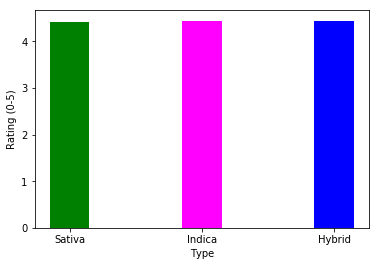

In [15]:
rating_int = data[['Rating']]
type_int = data[['Type']]

rating_int = rating_int.astype('float')
type_int = type_int.astype('int')


average_ratings_from_type = []
sativa_rating = 0
sativa_count = 0
indica_rating = 0
indica_count = 0
hybrid_rating = 0
hybrid_count = 0
for i in range(data.shape[0]):
    if type_int['Type'][i] == 0:
        sativa_rating = sativa_rating + rating_int['Rating'][i]
        sativa_count = sativa_count + 1
    elif type_int['Type'][i] == 1:
        indica_rating = indica_rating + rating_int['Rating'][i]
        indica_count = indica_count + 1
    elif type_int['Type'][i] == 2:
        hybrid_rating = hybrid_rating + rating_int['Rating'][i]
        hybrid_count = hybrid_count + 1
        
sativa_rating = sativa_rating / sativa_count
indica_rating = indica_rating / indica_count
hybrid_rating = hybrid_rating / hybrid_count
average_ratings_from_type.append(sativa_rating)
average_ratings_from_type.append(indica_rating)
average_ratings_from_type.append(hybrid_rating)

print('Average sativa rating:', "%.2f" % sativa_rating)
print('Average indica rating:', "%.2f" % indica_rating)
print('Average hybrid rating:', "%.2f" % hybrid_rating)


plt.bar(['Sativa','Indica', 'Hybrid'], average_ratings_from_type, width = 0.3, color = ['green','magenta','blue'])
plt.xlabel('Type')
plt.ylabel('Rating (0-5)')
type_xticks = ['Sativa','Indica', 'Hybrid']
plt.xticks(type_xticks)
plt.show()

So all types of cannabis have a similar rating, the only difference being sativa is rated slightly lower than indica and hybrid. Lets look to see if we can predict the rating of a strain given its flavours, effects and type. Since we are predicting a continuous output, linear regression will be used for this prediction. 

In [16]:
x_train_rating_flavour_one = x_train_type_flavors_one
x_test_rating_flavour_one = x_test_type_flavors_one

rating_training_int = training_data[['Rating']]
rating_training_int = rating_training_int.astype('float')

rating_testing_int = testing_data[['Rating']]
rating_testing_int = rating_testing_int.astype('float')

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
linear = LinearRegression()
linear.fit(x_train_rating_flavour_one, rating_training_int)
linear_score = linear.score(x_test_rating_flavour_one, rating_testing_int)
linear_predict = linear.predict(x_test_rating_flavour_one)

for i in range(len(linear_predict)):
    linear_predict[i][0] = round(linear_predict[i][0], 1)

r_score = r2_score(linear_predict, rating_testing_int)
print("The r-squared coefficient is:", "%.2f" % r_score)
print('The accuracy is:', "%.2f" % linear_score)

The r-squared coefficient is: -8.04
The accuracy is: -0.18


In [18]:
x_train_rating_effects_one = x_train_type_effects_one
x_test_rating_effects_one = x_test_type_effects_one

linear1 = LinearRegression()
linear1.fit(x_train_rating_effects_one, rating_training_int)
linear_score1 = linear1.score(x_test_rating_effects_one, rating_testing_int)
linear_predict1 = linear1.predict(x_test_rating_effects_one)

for i in range(len(linear_predict1)):
    linear_predict1[i][0] = round(linear_predict1[i][0], 1)

r_score1 = r2_score(linear_predict1, rating_testing_int)
print("The r-squared coefficient is:", "%.2f" % r_score1)
print('The accuracy is:', "%.2f" % linear_score1)

The r-squared coefficient is: -18.91
The accuracy is: -0.02


Using type, effects and flavors to predict rating.

In [19]:
rating_training_pred = pd.merge(x_train_rating_effects_one, x_train_rating_flavour_one, right_index=True, left_index=True)
rating_training_pred = pd.merge(rating_training_pred, y_train_type_flavors, right_index=True, left_index=True)

rating_testing_pred = pd.merge(x_test_rating_effects_one, x_test_rating_flavour_one, right_index=True, left_index=True)
rating_testing_pred = pd.merge(rating_testing_pred, y_test_type_flavors, right_index=True, left_index=True)


In [20]:
linear2 = LinearRegression()
linear2.fit(rating_training_pred, rating_training_int)
linear_score2 = linear2.score(rating_testing_pred, rating_testing_int)
linear_predict2 = linear2.predict(rating_testing_pred)

for i in range(len(linear_predict2)):
    linear_predict2[i][0] = round(linear_predict2[i][0], 1)
    


r_score2 = r2_score(linear_predict2, rating_testing_int)
print("The r-squared coefficient is:", "%.2f" % r_score2)
print('The accuracy is:', "%.2f" % linear_score2)

The r-squared coefficient is: -4.61
The accuracy is: -0.36


It is clearly shown that there is no correlation between any of the features and the rating (using a linear regression model). This implies that all flavours, types and effects can range in quality. For example, the effect 'uplifting' might not be the greatest feeling for a particular strain. Or 'uplifting' might be a really good quality for that particular strain and so people rate the strain higher. It is not clear why this is. 


Now lets try to predict the type with both the effects and flavours!

In [21]:
combined_type_pred_train = rating_training_pred.drop(columns = ['Type'])
combined_type_pred_test = rating_testing_pred.drop(columns = ['Type'])

gnb3 = GaussianNB()
gnb3.fit(combined_type_pred_train, y_train_type_flavors)
gnb_score3 = gnb3.score(combined_type_pred_test, y_test_type_flavors)
print('The score for naive Bayes is:' , gnb_score3)

log_reg3 = LogisticRegression()
log_reg3.fit(combined_type_pred_train, y_train_type_flavors)
log_reg_score3 = log_reg3.score(combined_type_pred_test, y_test_type_flavors)
print('The score for logistic regression is:' , log_reg_score3)

svm3 = svm.SVC()
svm3.fit(combined_type_pred_train, y_train_type_flavors)
svm_score3 = svm3.score(combined_type_pred_test, y_test_type_flavors)
print('The score for SVM is:' , svm_score3)

max_score3 = max(svm_score3,log_reg_score3,gnb_score3)
if max_score3 == svm_score3:
    print('The most accurate classifier is SVM!')
elif max_score3 == log_reg_score3:
        print('The most accurate classifier is Logistic Regression!')
elif max_score3 == gnb_score3:
        print('The most accurate classifier is Naive Bayes!')

/anaconda3/envs/pytorch2/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The score for naive Bayes is: 0.28923076923076924
The score for logistic regression is: 0.6338461538461538
The score for SVM is: 0.6
The most accurate classifier is Logistic Regression!


The next section revolves around using Term-Frequency Inverse Document Frequency (TF-IDF) in order to create two functions: 1) a function that recommends a strain based off of another strain, and 2) a function that recommends a strain based off of the description that a user desires.

In [22]:
#TF-IDF simlarity

#Separating the data
description_data = data[['Strain','Description']]

#Removing all 'stop words' such as "the", "a" and replacing NaN with empty strings
tfidf = TfidfVectorizer(stop_words='english')
description_data['Description'] = description_data['Description'].fillna('')

#Construct the tfidf matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(description_data['Description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

/anaconda3/envs/pytorch2/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(2163, 9101)

This means that there are 9101 unique words used to describe the strains.

I will use the cosine similarity as the distance metric between strains. It is defined as:

cosine(x,y) = (x.y.T)/(||x||.||y||)

This is just the normalized dot-product between x and y, so we can use linear_kernal. Then the goal will be to return the top 5 most similar strains based off of the cosine similarity matrix.

In [23]:
strain_distance = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(description_data.index, index=description_data['Strain'])

def recommend_a_strain(Strain, cosine_similarity=strain_distance):
    #Locate index of that strain
    index = indices[Strain]
    
    #Return list of cosine similarity scores for the given index and then sort them
    similarity = list(enumerate(cosine_similarity[index]))
    similarity = sorted(similarity, key=lambda x: x[1], reverse=True)
    
    #Return list of top 5 strains while ignoring the first because it is the input strain
    similarity = similarity[1:6]
    
    #Returning the indice with the strain
    strain_indices = [i[0] for i in similarity]
    return description_data['Strain'].iloc[strain_indices]


In [24]:
#Examples
recommend_a_strain('Blueberry')

115                Arcticblue
576              Crystalberry
271                 Blue-Hash
578        Dj-Short-Blueberry
238    Blackberry-X-Blueberry
Name: Strain, dtype: object

In [25]:
recommend_a_strain('Og-Kush')

176        Berry-Og
1671    Sfv-Og-Kush
992         Ig-Kush
956     Hellfire-Og
1664     Rudeboi-Og
Name: Strain, dtype: object

In [26]:
def return_description(strain):
    j = -1
    for i in data['Strain']:
        j += 1
        if i == strain:
            print(data['Description'][j])
            return

In [27]:
return_description('Haze')

The illustrious Haze sativa first took root in Santa Cruz, California during the 1960s where long growing seasons accommodated her lengthy flowering cycle. Since then, Haze has become the proud parent of countless hybrids around the globe, passing on its genetics from Colombia, Mexico, Thailand, and South India. Although Haze cultivators must wait patiently for Haze flowers to reach full maturation, few strains can match the high-energy, creative buzz provided by this sativa staple. Haze's aroma is typically characterized by a spicy scent accented by hints of citrus and earthy sweetness.


We have now made a recommender system based off of another strain. We will make a system where the input is a description and the output is the most similar strain. 

In [28]:
description_data2 = data[['Strain','Description']]

def strain_from_description(Description, description_data2=description_data2):
    #Insert new strain to description and then clean
    #description_data2 = description_data2 + new strain (name and description)
    d = {'Strain': ['Random-Strain'], 'Description': [Description]}
    df2 = pd.DataFrame(data=d)
    
    description_data2 = description_data2.append(df2, ignore_index=True)
    description_data2['Description'] = description_data2['Description'].fillna('')
   
    #Construct the tfidf matrix by fitting and transforming the data
    tfidf_matrix2 = tfidf.fit_transform(description_data2['Description'])
    
    #Define distance metric and index
    strain_distance = linear_kernel(tfidf_matrix2, tfidf_matrix2)
    indices = pd.Series(description_data2.index, index=description_data2['Strain'])
    
    #Create new strain with index
    index = indices['Random-Strain']
    print(index)
    #Return list of cosine similarity scores for the given index and then sort them
    similarity = list(enumerate(strain_distance[index]))

    similarity = sorted(similarity, key=lambda x: x[1], reverse=True)

    #Return list of top 5 strains while ignoring the first because it is the input strain
    similarity = similarity[1:6]
    
    #Returning the indice with the strain
    strain_indices = [i[0] for i in similarity]
    return description_data2['Strain'].iloc[strain_indices]

In [29]:
#Examples
strain_from_description('relaxing and uplifting with pain relief')

2163


1780       Sour-Flower
2093    White-Elephant
1537      Purple-Arrow
366          Bubblegun
1838        Strawberry
Name: Strain, dtype: object

In [30]:
return_description('Sour-Flower')

Sour Flower provides an uplifting sativa high and is good for relieving pain and anxiety. 


In [31]:
#Examples
strain_from_description('giggly and hungry, perfect for video games')

2163


1769              Sour-Bubba
2008                   Trash
1173    Lemon-Larry-Lavender
906               Hades-Haze
2161               Zombie-Og
Name: Strain, dtype: object

In [32]:
return_description('Sour-Bubba')

Sour Bubba blends two famous strains that are robust all on their ownbut, when unified,show unique flavors and effects that speak to their long, potent lineages. With forward-leaning mental stimulation brought on by Diesel and a high-end Kush oriented body aura brought on byBubba, Sour Bubba relaxes while providing ample mental energy to enjoy stationary activities like board games, video games, and movies. 


In [33]:
#Examples
strain_from_description('before bed body high')

2163


320      Blueberry-Kush
1499        Pink-Sunset
2073            Webster
592         Darkside-Og
1965    The-Brotherhood
Name: Strain, dtype: object

In [34]:
return_description('Blueberry-Kush')

Blueberry Kush is a strong indica strain that slowly brings on a heavy body sensation, helping patients forget their pain and relax. Originally from Oregon, this strain is a hybridofBlueberryandOG Kush, which is evident in its fresh berry aroma with notes of earthy herbalness. This indica is best for evenings or before bed.
